In [1]:
# Import the relevent Files: 

import chess
import chess.engine
import random
import numpy
import pydot
import graphviz

import numpy as np

from tempfile import TemporaryFile

#Import Tensorflow
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.utils import plot_model

#import keras load model
from keras.models import load_model

## Create Random Position Generator and Evaluation Function

In [4]:
# This produces a random board which will later be analyzed
def randomBoardGenerator(max_depth=200):
    chessBoard = chess.Board()
    depth = random.randrange(0, max_depth)

#for i in range of the depth,create a list of all moves. Choose a random value from that list.
#make move, if game is over break, if not return the chessboard
    for i in range(depth):
        allMoves = list(chessBoard.legal_moves)
        randomMove = random.choice(allMoves)
        chessBoard.push(randomMove)
        if chessBoard.is_game_over():
            break

    return chessBoard

# this opens stockfish, gets an analysis and then returns the value
def stockfish(board, depth):
    with chess.engine.SimpleEngine.popen_uci('C:/Users/SeanM/OneDrive/Documents/GitHub/GarryChess/predictions/stockfish/stockfish_15_x64_avx2.exe') as sf:
        result = sf.analyse(board, chess.engine.Limit(depth=depth))
        score = result['score'].white().score()
    return score

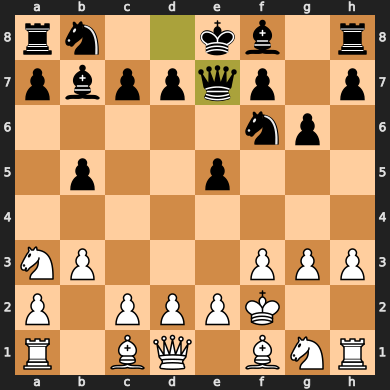

In [5]:
board = randomBoardGenerator()
board

In [6]:
print(board)

r n . . k b . r
p b p p q p . p
. . . . . n p .
. p . . p . . .
. . . . . . . .
N P . . . P P P
P . P P P K . .
R . B Q . B N R


In [4]:
#This prints the value of the board position. Utilizng the Stockfish Engine.
print(stockfish(board, 10))

1625


## Create a chess representation for Tensorflow

In [5]:
boardPositions = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}

In [6]:
# example: h3 -> 17
def square_to_index(square):
    letter = chess.square_name(square)
    return 8 - int(letter[1]), boardPositions[letter[0]]

"""
Splits the board into a 3d matrix.
Matrix 1 represents all white pawns, 2 knights, 3 bishops, 4 Rooks, 5 Queen and 7 King.
Repeat for black Pieces.
The second to last matrixes represent all the available squares where white can move.
The final matrix represents all the available squares where black can move.
"""
def split_dims(board):
    board3d = numpy.zeros((14, 8, 8), dtype=numpy.int8)

  # here we add the pieces's view on the matrix
    for piece in chess.PIECE_TYPES:
        for square in board.pieces(piece, chess.WHITE):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
            idx = numpy.unravel_index(square, (8, 8))
            board3d[piece + 5][7 - idx[0]][idx[1]] = 1

  # add attacks and valid moves too
  # so the network knows what is being attacked
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[12][i][j] = 1
    board.turn = chess.BLACK
    for move in board.legal_moves:
        i, j = square_to_index(move.to_square)
        board3d[13][i][j] = 1
    board.turn = aux

    return board3d

In [7]:
#Here you can see the representation for the board which is being utilized.
split_dims(board)

array([[[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        

## Create Dataset.

In [8]:
# Here we will populate the data. This Creates two arrays and then saves them to an npz file.
"""
Initiate x and y
for i in the range of value
Assign a new board
Assign numeric representation of the board
Assign Valuation of the board 
if the valuation is none, start loop over 
append values to x and y 
print done and save to npz file
"""
def populateData(value):
    x = []
    y = []
    for i in range(value):
        newBoard = randomBoardGenerator()
        positionsRep = split_dims(newBoard)
        valuationRep = stockfish(newBoard, 1)
        if valuationRep == None:
            continue
        x.append(positionsRep)
        y.append(valuationRep)
    print("Done")
    np.savez('dataLast', b=x, v=y)

In [10]:
#Insert Value here for your dataset
populateData()

Done


In [ ]:
d = np.load("dataLast.npz")

In [ ]:
d['b']

In [ ]:
d['v']

## Convulutional Model

In [25]:
def buildModelConv(conv_size, conv_depth):
    # Assign the the three D board and dictate the input shape for the model
    board3d = layers.Input(shape=(14, 8, 8))

    # adding the convolutional layers
    x = board3d
    for i in range(conv_depth):
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, 'relu')(x)
    x = layers.Dense(1, 'sigmoid')(x)

    return models.Model(inputs=board3d, outputs=x)

### Residual Network Model

In [21]:
def buildModelRes(conv_size, conv_depth):
    board3d = layers.Input(shape=(14, 8, 8))

  # adding the convolutional layers
      x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
      for _ in range(conv_depth):
        previous = x
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Add()([x, previous])
        x = layers.Activation('relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, 'sigmoid')(x)

    return models.Model(inputs=board3d, outputs=x)

### Begin Training

In [26]:
#build the convulutional model
model = buildModelConv(32, 4)

In [27]:
#Open the dataset from earlier
def getDataset():
    container = numpy.load('dataset.npz')
    b, v = container['b'], container['v']
    v = numpy.asarray(v / abs(v).max() / 2 + 0.5, dtype=numpy.float32) # normalization (0 - 1)
    return b, v

# make the x train and y train splits
x_train, y_train = getDataset()
print(x_train.shape)
print(y_train.shape)

(1500000, 14, 8, 8)
(1500000,)


In [29]:
model.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,
          batch_size=2048,
          epochs=10,
          verbose=1,
          validation_split=0.1,
          callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
                     callbacks.EarlyStopping(monitor='loss', patience=15, min_delta=1e-4)])

model.save('model.h5')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 14, 8, 8)]        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 14, 8, 32)         2336      
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 8, 32)         9248      
                                                                 
 conv2d_22 (Conv2D)          (None, 14, 8, 32)         9248      
                                                                 
 conv2d_23 (Conv2D)          (None, 14, 8, 32)         9248      
                                                                 
 flatten_5 (Flatten)         (None, 3584)              0         
                                                                 
 dense_10 (Dense)            (None, 64)                2294

## Test Playing Against AI

In [2]:
model = load_model('model.h5')

In [3]:
# used for the minimax algorithm
def minimax_eval(board):
  board3d = split_dims(board)
  board3d = numpy.expand_dims(board3d, 0)
  return model.predict(board3d)[0][0]


def minimax(board, depth, alpha, beta, maximizing_player):
    if depth == 0 or board.is_game_over():
        return minimax_eval(board)
  
    if maximizing_player:
        max_eval = -numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, False)
            board.pop()
            max_eval = max(max_eval, eval)
            alpha = max(alpha, eval)
            if beta <= alpha:
                break
        return max_eval
    else:
        min_eval = numpy.inf
        for move in board.legal_moves:
            board.push(move)
            eval = minimax(board, depth - 1, alpha, beta, True)
            board.pop()
            min_eval = min(min_eval, eval)
            beta = min(beta, eval)
            if beta <= alpha:
                break
    return min_eval


# this is the actual function that gets the move from the neural network
def get_ai_move(board, depth):
    max_move = None
    max_eval = -numpy.inf

    for move in board.legal_moves:
        board.push(move)
        eval = minimax(board, depth - 1, -numpy.inf, numpy.inf, False)
        board.pop()
        if eval > max_eval:
            max_eval = eval
            max_move = move
  
    return max_move

In [7]:
board = chess.Board()

with chess.engine.SimpleEngine.popen_uci('C:/Users/SeanM/OneDrive/Documents/GitHub/GarryChess/predictions/stockfish/stockfish_15_x64_avx2.exe') as engine:
      while True:
        move = get_ai_move(board, 1)
        board.push(move)
        print(move)
        print(f'\n{board}')
        if board.is_game_over():
              break

        move = engine.analyse(board, chess.engine.Limit(time=1), info=chess.engine.INFO_PV)['pv'][0]
        board.push(move)
        print(f'\n{board}')
        if board.is_game_over():
              break

1/1 [==============================] - 0s 17ms/step
e2e4

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R

r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R
1/1 [==============================] - 0s 13ms/step
d1h5

r n b q k b n r
p p . p p p p p
. . . . . . . .
. . p . . . . Q
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B . K B N R

r n b q k b n r
p p . p . p p p
. . . . p . . .
. . p . . . . Q
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B . K B N R
1/1 [==============================] - 0s 18ms/step
h5f7

r n b q k b n r
p p . p . Q p p
. . . . p . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B . K B N R

r n b q . b n r
p p . p . k p p
. . . . p . . .
. . p . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B . K B N R
1/1 [==============================] - 0s 14ms/step
f1b

1/1 [==============================] - 0s 13ms/step
b5a4

r n b . . b . r
p p . p . k p p
. . . . p . . .
. . p . . . n .
B . . P . . . .
. . . . . . . .
P . P . K P P P
. . . . . . . q

r n b . . b . r
p p . p . k p p
. . . . p . . .
. . p . . . n .
B . . P . . . .
. . . . . . . .
P . P . K P q P
. . . . . . . .
1/1 [==============================] - 0s 13ms/step
e2d1

r n b . . b . r
p p . p . k p p
. . . . p . . .
. . p . . . n .
B . . P . . . .
. . . . . . . .
P . P . . P q P
. . . K . . . .

r n b . . b . r
p p . p . k p p
. . . . p . . .
. . . . . . n .
B . p P . . . .
. . . . . . . .
P . P . . P q P
. . . K . . . .
1/1 [==============================] - 0s 17ms/step
a4c6

r n b . . b . r
p p . p . k p p
. . B . p . . .
. . . . . . n .
. . p P . . . .
. . . . . . . .
P . P . . P q P
. . . K . . . .

r n b . . b . r
p p . p . k p p
. . B . p . . .
. . . . . . n .
. . p P . . . .
. . . . . . . .
P . P . . P . P
. . . K . q . .
1/1 [==============================] - 0s 13ms/step
d1d